In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from itertools import combinations 

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


-------------------------
*up bond yield, lower policy and vice versa*

bond yields > asset yields

policy rate + gdp > loans > asset yields

CASA level and policy rates > COF

asset yields + COF > NII

### Data Preprocessing

In [75]:
data = os.path.join('datasets', '9M21_asset_yield_data_ds.csv')

df = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True)

df.head(-1)

,t3m,t5yr,t10yr,yield_pbs,policy
2001-01-01,10.205600,13.851750,14.614300,NaN,11.00
2001-04-01,9.826169,14.411108,15.104600,NaN,9.17
2001-07-01,9.727862,15.095631,15.604354,NaN,9.00
2001-10-01,10.012561,15.343682,16.316212,NaN,8.25
2002-01-01,7.491891,13.036672,14.351875,NaN,7.25
...,...,...,...,...,...
2020-04-01,2.502892,3.245492,3.581215,5.02,2.58
2020-07-01,1.337591,2.542379,2.804258,4.78,2.25
2020-10-01,1.178076,2.748985,3.008303,4.49,2.08
2021-01-01,1.080953,2.909859,3.561234,4.28,2.00


In [76]:
#gdp = df.real_gdp.dropna()
#loans = df.loans_ukb.dropna() 
#gdp_gth = df.gdp_gth.dropna() #
#loans_gth = df.loans_gth_ukb.dropna() #
#deposits = df.deposits_ukb.dropna()
#olf = df.olf.dropna() #
policy = df.policy.dropna()#
#asset_yld = df.yield_ukb.dropna() #
asset_yld = df.yield_pbs.dropna() 
#cof = df.cof_ukb.dropna() #
#nim = df.nim_ukb.dropna() #
#t10yr = bonds.dropna() # <-changed to quarterly averages
t10yr = df.t10yr.dropna()
t91day = df.t3m.dropna() #
t5yr = df.t5yr.dropna() #


series_asset_yld1 = [asset_yld, gdp_gth, policy, olf]
series_asset_yld2 = [asset_yld, t10yr, t91day, t5yr]
series_cof = [cof, deposits, policy]
series_nim = [nim, asset_yld, cof]
series_loan = [loans_gth, gdp_gth, policy, olf]


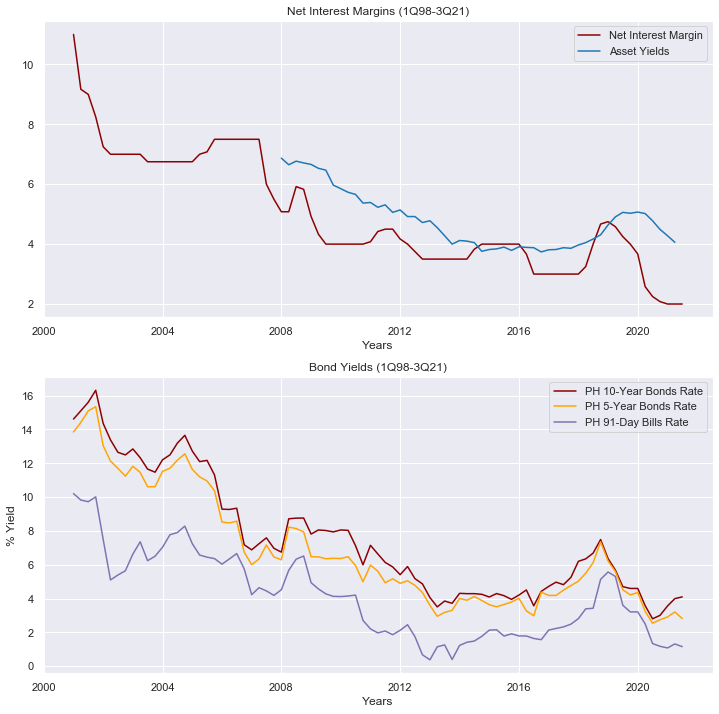

In [78]:
# plotting
def plots():

    sns.set(style="darkgrid")

    #fig = plt.figure(figsize=(12,24))
    fig = plt.figure(figsize=(12,12))

    '''plt.subplot(4, 1, 1)
    plt.plot(gdp_gth, color='darkred', label='Real GDP Growth (2018p)')
    plt.plot(loans_gth, color='tab:blue', label='UKB Loans Growth')
    plt.title('GDP and Loans Growth (1Q98-3Q21)')
    plt.legend(loc=3)
    plt.xlabel('Years')
    plt.ylabel('%')
    plt.axhline(linewidth=1, linestyle='dashed', color='k')'''

    '''plt.subplot(2, 1, 2)
    plt.plot(policy, color='tab:blue', label='Reverse Repurchase Rate')
    plt.plot(olf, color='darkred', label='Overnight Lending Facility')
    plt.title('Key Policy Rates (1Q98-3Q21)')
    plt.legend(loc=3)
    plt.xlabel('Years')
    #plt.ylabel('Y-o-Y Growth')'''

    plt.subplot(2, 1, 1)
    plt.plot(policy, color='darkred', label='Policy Rate')
    plt.plot(asset_yld, color='tab:blue', label='Asset Yields')
    #plt.plot(cof, color='orange', label='Cost of Funds')
    plt.title('Net Interest Margins (1Q98-3Q21)')
    plt.legend()
    plt.xlabel('Years')
    #plt.ylabel('index')

    plt.subplot(2, 1, 2)
    plt.plot(t10yr.bfill(), color='darkred', label='PH 10-Year Bonds Rate')
    plt.plot(t5yr.bfill(), color='orange', label='PH 5-Year Bonds Rate')
    plt.plot(t91day.bfill(), color='m', label='PH 91-Day Bills Rate')
    plt.title('Bond Yields (1Q98-3Q21)')
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel('% Yield')

    plt.show()

plots()

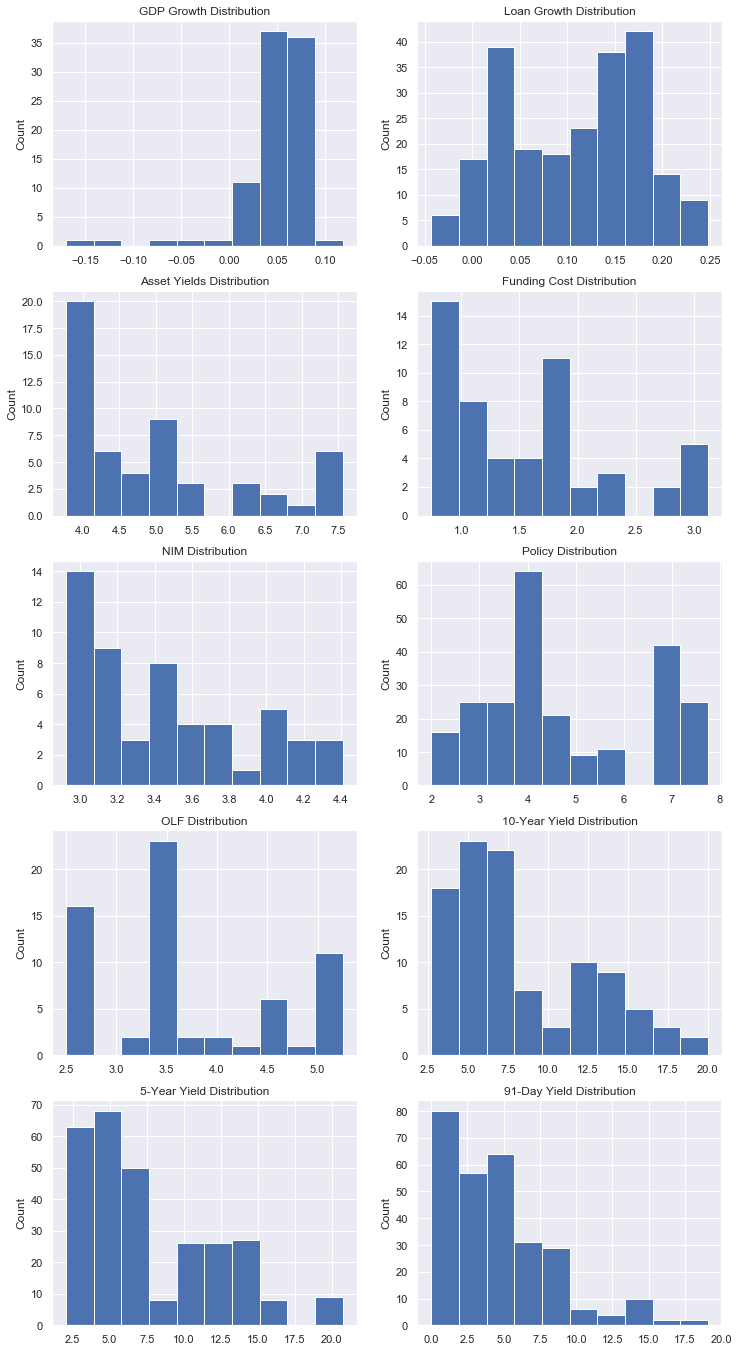

In [35]:
# checking for normality by plotting

def all_dist():
    fig = plt.figure(figsize=(12,24))

    plt.subplot(5,2,1)
    plt.hist(gdp_gth)
    plt.title('GDP Growth Distribution')
    plt.ylabel('Count')

    plt.subplot(5,2,2)
    plt.hist(loans_gth)
    plt.title('Loan Growth Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 3)
    plt.hist(asset_yld)
    plt.title('Asset Yields Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 4)
    plt.hist(cof)
    plt.title('Funding Cost Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 5)
    plt.hist(nim)
    plt.title('NIM Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 6)
    plt.hist(policy)
    plt.title('Policy Distribution')
    plt.ylabel('Count')

    plt.subplot(5, 2, 7)
    plt.hist(olf)
    plt.title('OLF Distribution')
    plt.ylabel('Count')
    
    plt.subplot(5, 2, 8)
    plt.hist(t10yr)
    plt.title('10-Year Yield Distribution')
    plt.ylabel('Count')
    
    plt.subplot(5, 2, 9)
    plt.hist(t5yr)
    plt.title('5-Year Yield Distribution')
    plt.ylabel('Count')
    
    plt.subplot(5, 2, 10)
    plt.hist(t91day)
    plt.title('91-Day Yield Distribution')
    plt.ylabel('Count')

    plt.show()
    
all_dist()

### Test for Stationarity

In [79]:
#testing for stationarity

def adf_test(series, name=None, num=None):
    result = adfuller(series)
    if name == None:
        name = str(series.name)
    if num != None:
        name = 'Series %s' % str(num)
    print('\n%s:' %name)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# [loans_gth, gdp_gth, asset_yld, cof, nim, policy, olf, t10yr, t5yr, t91day]
series = [asset_yld, policy, olf, t10yr, t5yr, t91day]
    
for s in series:
    adf_test(s)


yield_pbs:
ADF Statistic: -2.715582
p-value: 0.071381

policy:
ADF Statistic: -1.280420
p-value: 0.638082

olf:
ADF Statistic: -3.890438
p-value: 0.002106

t10yr:
ADF Statistic: -2.284305
p-value: 0.177080

t5yr:
ADF Statistic: -1.733958
p-value: 0.413707

t3m:
ADF Statistic: -2.394417
p-value: 0.143318


### Transformation
- Normalization,
- Differencing,
- Treating unequal variance,
- Adjusting for seasonality



#### Making Stationary

In [82]:
def normalize(series):
    ave, stdev = series.mean(), series.std()
    series = (series-ave)/stdev
    return series

def annual_vol(series):
    stdevs = series.groupby(series.index.year).std()
    return series.index.map(lambda d: stdevs.loc[d.year])

def variance_correct(series):
    return series/annual_vol(series)

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

def make_stationary(*data, plot=False, headers=True):
    stdata = []
    for d in data:
        if headers == True:
            header = d.name
        d = normalize(d)
        d = d.diff().dropna()
        # d = annual_vol(d)
        d = variance_correct(d)
        d = seasonality_correct(d).dropna()
        d.name = header
        stdata.append(d)
        
    if len(stdata) == 1:
        return stdata[0]
    else:
        return stdata



In [83]:
# [loans_gth, gdp_gth, asset_yld, cof, nim, policy, olf, t10yr, t5yr, t91day]
series = make_stationary(asset_yld, policy, t10yr, t5yr, t91day)

for s in series:
    adf_test(s)


yield_pbs:
ADF Statistic: -4.077692
p-value: 0.001054

policy:
ADF Statistic: -5.758672
p-value: 0.000001

olf:
ADF Statistic: -7.652541
p-value: 0.000000

t10yr:
ADF Statistic: -6.756230
p-value: 0.000000

t5yr:
ADF Statistic: -6.958387
p-value: 0.000000

t3m:
ADF Statistic: -6.825413
p-value: 0.000000


In [84]:
#loans_gth = make_stationary(loans_gth)
#gdp_gth = make_stationary(gdp_gth)
asset_yld = make_stationary(asset_yld)
#cof = make_stationary(cof)
#nim = make_stationary(nim)
policy = make_stationary(policy)
#olf = make_stationary(olf)
t10yr = make_stationary(t10yr)
t5yr = make_stationary(t5yr)
t91day = make_stationary(t91day)

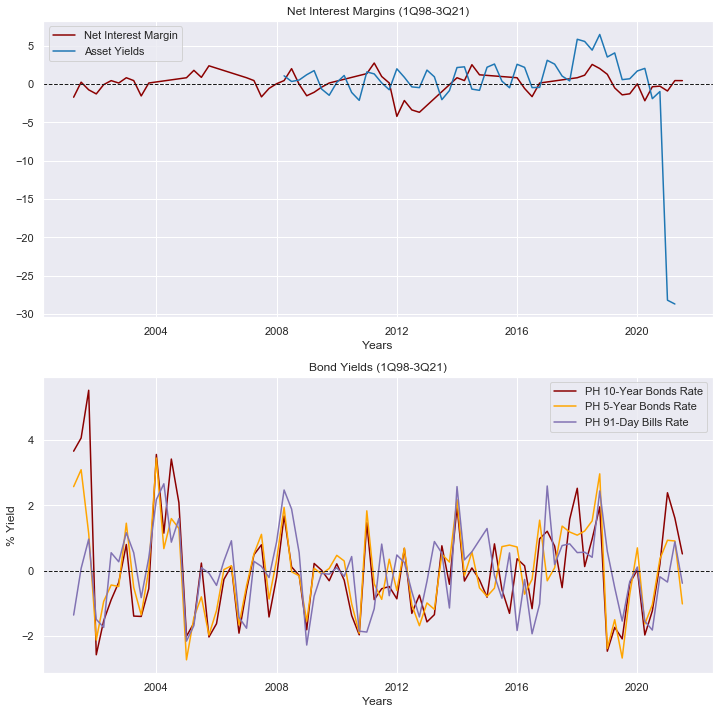

In [87]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(12,12))

'''plt.subplot(4, 1, 1)
plt.plot(gdp_gth, color='darkred', label='Real GDP Growth (2018p)')
plt.plot(loans_gth, color='tab:blue', label='UKB Loans Growth')
plt.title('GDP and Loans Growth (1Q98-3Q21)')
plt.legend(loc=3)
plt.xlabel('Years')
plt.ylabel('%')
plt.axhline(linewidth=1, linestyle='dashed', color='k')'''

'''plt.subplot(2, 1, 2)
plt.plot(policy, color='tab:blue', label='Reverse Repurchase Rate')
plt.plot(olf, color='darkred', label='Overnight Lending Facility')
plt.title('Key Policy Rates (1Q98-3Q21)')
plt.legend(loc=3)
plt.xlabel('Years')
#plt.ylabel('Y-o-Y Growth')'''

plt.subplot(2, 1, 1)
plt.plot(policy, color='darkred', label='Policy Rate')
plt.plot(asset_yld, color='tab:blue', label='Asset Yields')
#plt.plot(cof, color='orange', label='Cost of Funds')
plt.title('Net Interest Margins (1Q98-3Q21)')
plt.legend()
plt.xlabel('Years')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.subplot(2, 1, 2)
plt.plot(t10yr.bfill(), color='darkred', label='PH 10-Year Bonds Rate')
plt.plot(t5yr.bfill(), color='orange', label='PH 5-Year Bonds Rate')
plt.plot(t91day.bfill(), color='m', label='PH 91-Day Bills Rate')
plt.title('Bond Yields (1Q98-3Q21)')
plt.legend()
plt.xlabel('Years')
plt.ylabel('% Yield')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.show()


### Running Granger Causality on Corrected Data

In [89]:
def granger(s1, s2, lag=6):
    granger_df = pd.concat([s1, s2], axis=1).dropna()
    grangercausalitytests(granger_df, lag)
    
'''comb = [[loans_gth, gdp_gth],
       [loans_gth, policy],
       [nim, cof],
       [nim, asset_yld],
       [cof, policy],
       [asset_yld, gdp_gth],
       [asset_yld, policy],
       [asset_yld, t10yr],
       [asset_yld, t5yr],
       [asset_yld, t91day]]'''


#cof <- policy

comb = [[asset_yld, policy],
       [asset_yld, t10yr],
       [asset_yld, t5yr],
       [asset_yld, t91day]]

In [111]:
#try on every combination
num = 0
for c in comb:
    num += 1
    print('Granger Causality Results for Relation %s' %str(num))
    print('-------------------------------------------------')
    print('\nBetween %s' %str(c[0].name)+' and '+str(c[1].name))
    print('\n%s as Affected: ' %str(c[0].name))
    granger(c[0], c[1], lag=4)
    print('\n%s as Affected: ' %str(c[1].name))
    granger(c[1], c[0], lag=4)
    print('\n=================================================\n')

Granger Causality Results for Relation 1
-------------------------------------------------

Var A as Affected: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0732  , p=0.7884  , df_denom=33, df_num=1
ssr based chi2 test:   chi2=0.0799  , p=0.7774  , df=1
likelihood ratio test: chi2=0.0798  , p=0.7776  , df=1
parameter F test:         F=0.0732  , p=0.7884  , df_denom=33, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1682  , p=0.8459  , df_denom=30, df_num=2
ssr based chi2 test:   chi2=0.3926  , p=0.8218  , df=2
likelihood ratio test: chi2=0.3904  , p=0.8227  , df=2
parameter F test:         F=0.1682  , p=0.8459  , df_denom=30, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7005  , p=0.5599  , df_denom=27, df_num=3
ssr based chi2 test:   chi2=2.6465  , p=0.4494  , df=3
likelihood ratio test: chi2=2.5486  , p=0.4666  , df=3
parameter F test:         F=0.7005  , p=0.5599  , df_denom=2

### Model Fitting


Asset Yield:


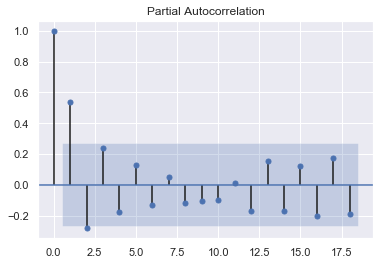

Policy:


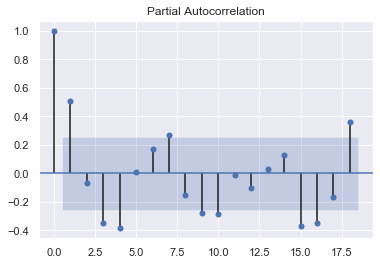

PH 10YR:


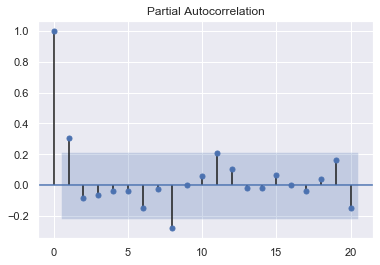

PH 5YR:


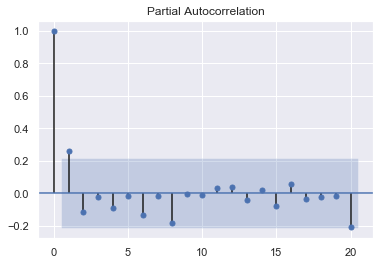

PH 91D:


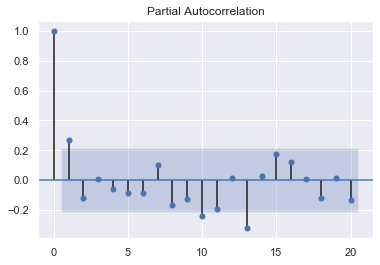

In [93]:
# Plotting partial autocorrelation
series = [asset_yld, policy, t10yr, t5yr, t91day]
s_names = ['Asset Yield', 'Policy', 'PH 10YR', 'PH 5YR', 'PH 91D']

ind = 0
for s in series:
    print('%s:'%s_names[ind])
    plot_pacf(s)
    ind += 1
    plt.show()

#### Fitting and selecting best model

In [97]:
## Automate

def fit_tsmodel(data, model='VAR', lags=4):
    models = ['VAR','SARIMAX']

    if model in models:
        if model == models[0]:
            model = VAR
        elif model == models[1]:
            model == SARIMAX
    else:
        print('Model not supported')
        return None
    
    fmodel = model(data)          
    res = fmodel.fit(maxlags=lags)
    return res

def create_df(*series):
    df = pd.concat(series, axis=1).bfill().dropna()
    n = []
    for i in series:
        n.append(i.name)
    df.columns = n
    return df

In [98]:
# loop through combos
# to check how many possible equations exist
series = [policy, t10yr, t5yr, t91day]
depvar = [asset_yld]
c_list = []
MAX_COMB = 5

# put constraints function where loans/loans grwoth as first item in list
for i in range(1, MAX_COMB):
    l = list(combinations(series, i))
    print('No. of series of combination: %s' %len(l))
    c_list.extend(l)

print('Total no. of combinations: %s \n' %len(c_list))
#print(c_list)


No. of series of combination: 4
No. of series of combination: 6
No. of series of combination: 4
No. of series of combination: 1
Total no. of combinations: 15 



In [100]:
df1 = create_df(asset_yld, policy, t10yr, t5yr, t91day)
df1 = df1.loc['2008-01-01':]

In [117]:
res1 = fit_tsmodel(df1,lags=3)
res1.summary()

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Oct, 2021
Time:                     17:07:05
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    6.88802
Nobs:                     51.0000    HQIC:                   5.01568
Log likelihood:          -380.201    FPE:                    52.8352
AIC:                      3.85771    Det(Omega_mle):         13.5021
--------------------------------------------------------------------
Results for equation yield_pbs
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.077216         0.916913            0.084           0.933
L1.yield_pbs         0.974989         0.164700            5.920           0.000
L1.policy            0.539860         0.585881            0.

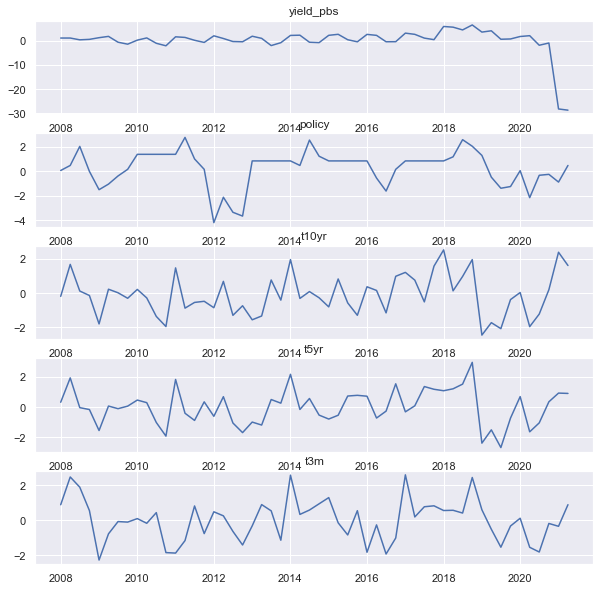

<Figure size 1296x1728 with 0 Axes>

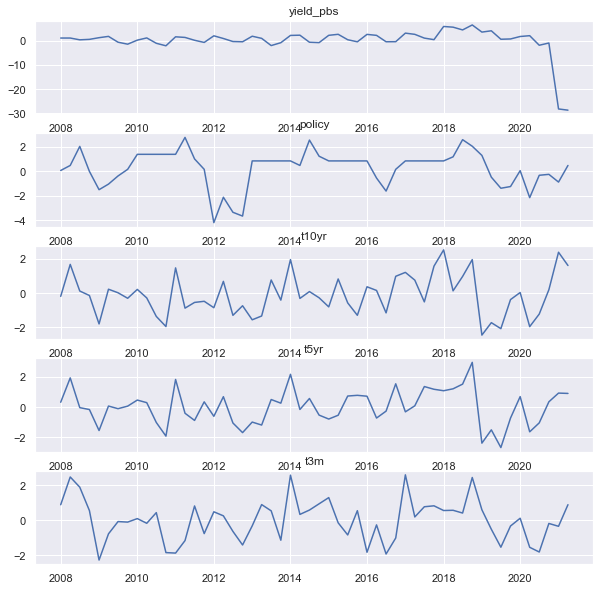

In [115]:
fig = plt.figure(figsize=(18,24))

res1.plot()

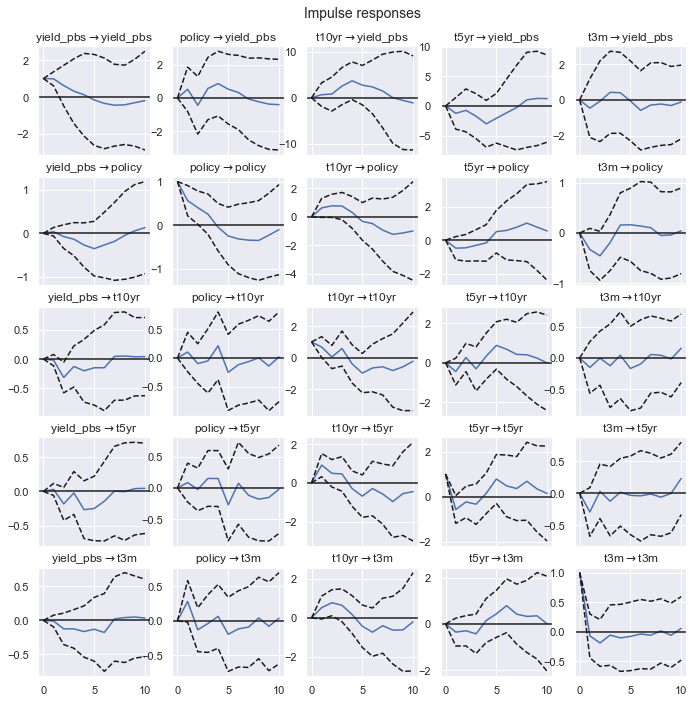

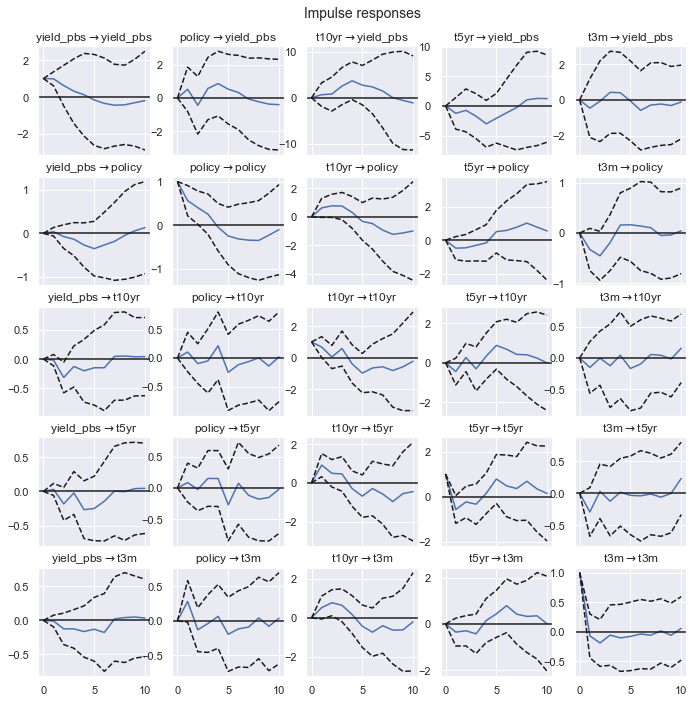

In [116]:
irf = res1.irf(10)
irf.plot(orth=False)

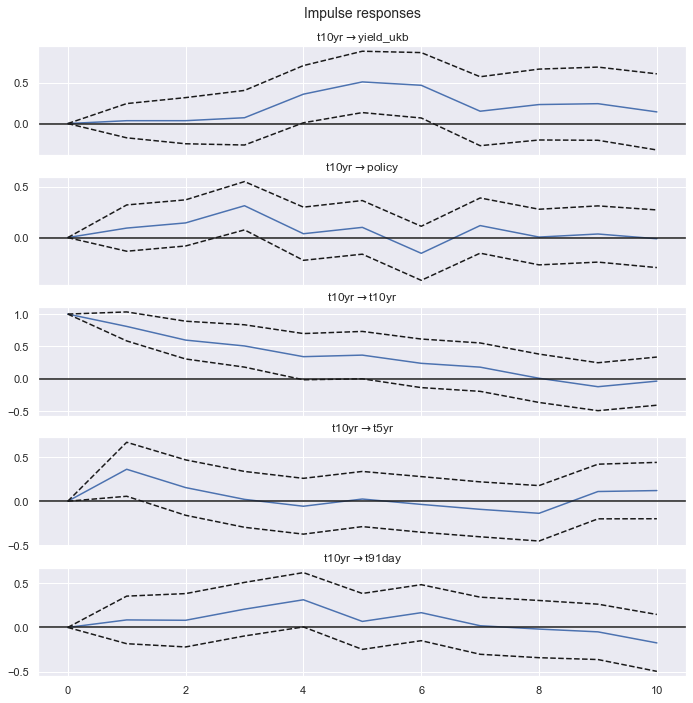

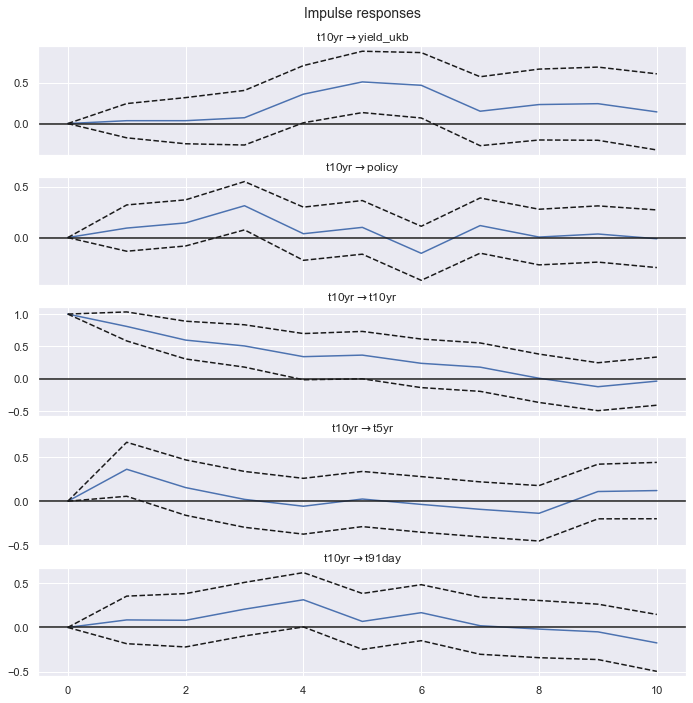

In [71]:
irf.plot(impulse='t10yr')

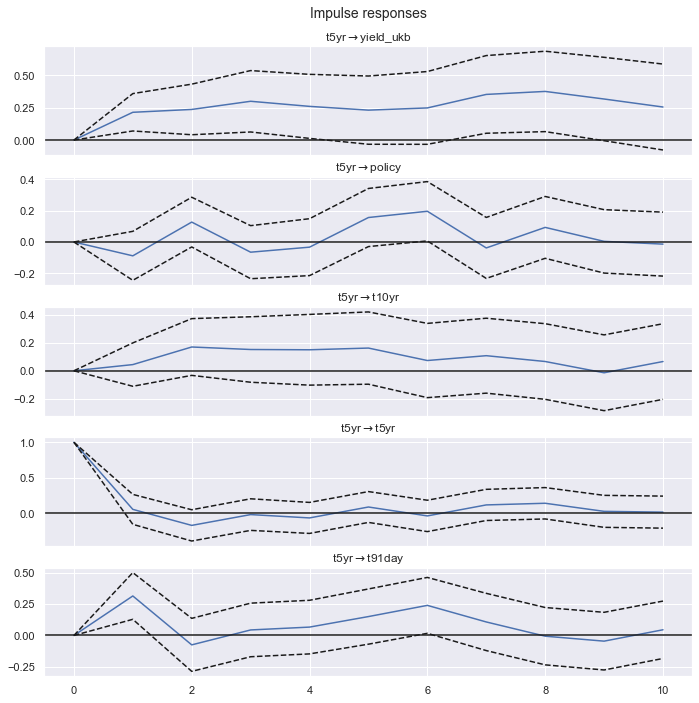

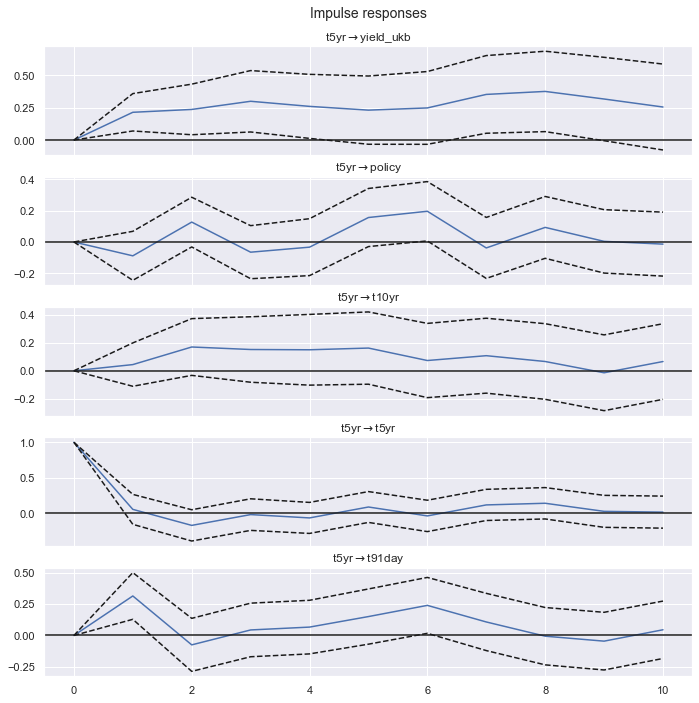

In [72]:
irf.plot(impulse='t5yr')

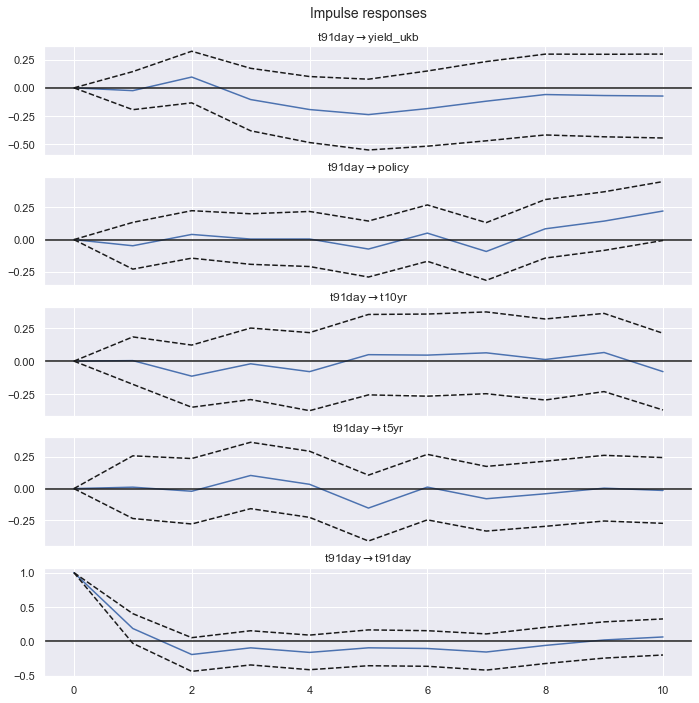

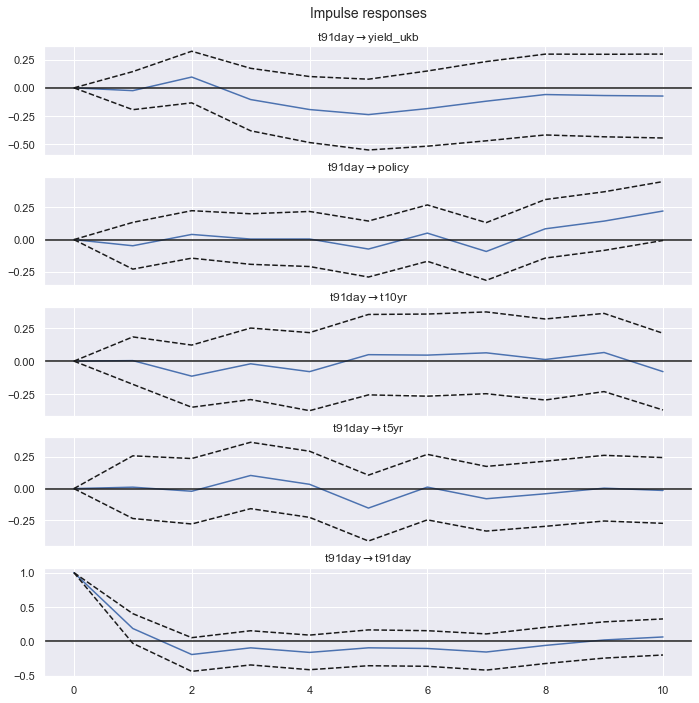

In [73]:
irf.plot(impulse='t91day')

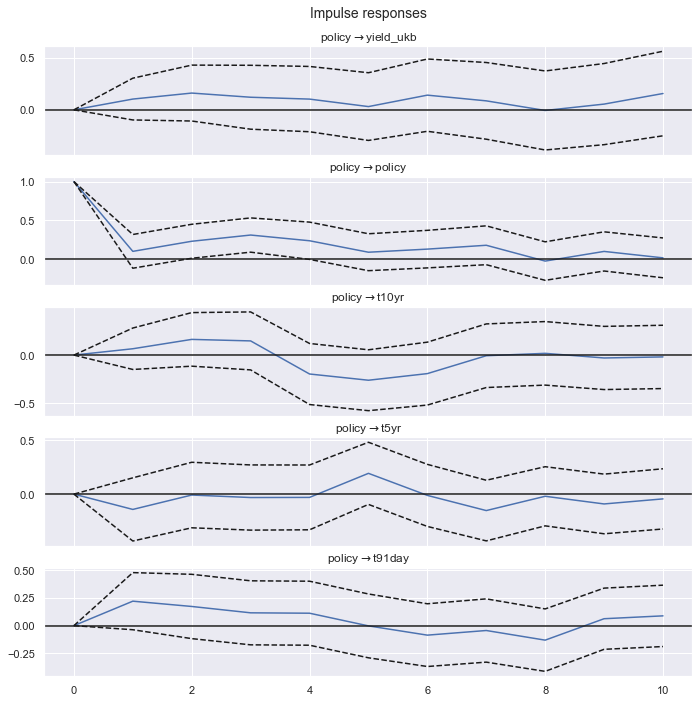

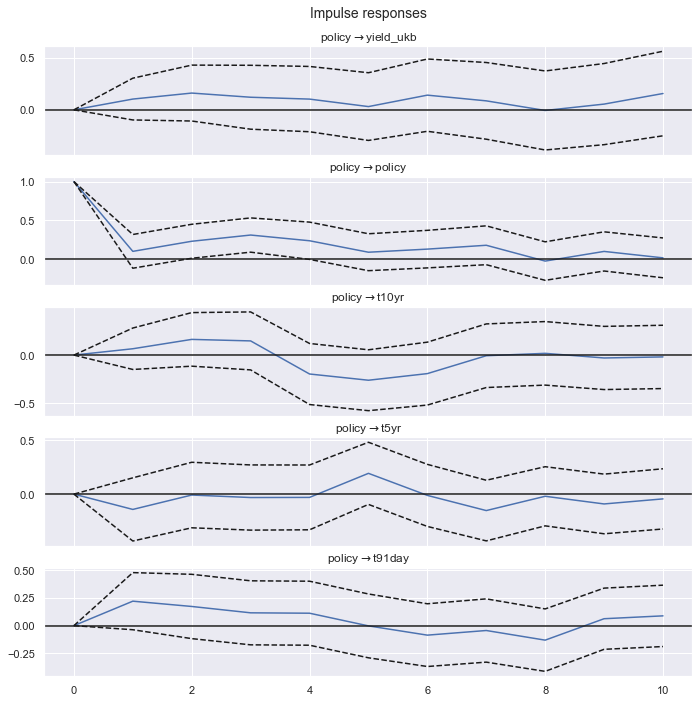

In [74]:
irf.plot(impulse='policy')